**TMA4320: Prosjekt i Fysikk - Jo Andersson Stokke, Jonas Armonas**

Vi skal i denne oppgaven bruke en simplifisert modell for å se på hvordan havet tar opp CO2 fra atmosfæren. Spesielt skal vi se på to de to tilfellene med grunn sjø (dyp på 100 meter) og dyp sjø (dyp på 4000 meter). 

Om modellen:
Modellen som brukes er diffusjons(varme) ligningen, men i en ikke-lineær variant det diffusjons"konstanten" avhenger med dypden. Det er også i denne modellen sett bort i fra variasjon i planet bestemt av en gitt dybde, slik at kun en romlig variabel blir brukt.

In [28]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
from numba import jit
"""Solver"""

@jit(nopython = True)
def tdma_solver(a, b, c, d): #Oppgit funksjon som raskt løser ligningssystemer som er tridiagonale. 
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x


"""Constants"""
L = 100 #meter, L er dybde på konveksjonssonen
K0 = 10E-3 #meter^2/sekund
Ka = 2*10E-2 #meter^2/sekund
Kb = 5*10E-2 #meter^2/sekund
za = 7 #meter
zb = 10 #meter
kw = 6.97E-5 #m/s, masstransfer koefficient med antatt konstant vindfart = 10m/s
N = 1000 #romlige oppdelinger
M = 10000 #oppdelinger i tid

def moleToPpm(a): #Gjør om mol av "a" til ppm i havet
    watermole = 1/(18.02E-6) #antall molekyler vann i 1 kubikkmeter i følge https://www.aqua-calc.com/calculate/mole-to-volume-and-weight/substance/water
    ratio = a/watermole
    return ratio*10**6


Lager Matrisene R og L med som inneholder det diskrete differensialet (finite-differential) pakket et objekt.

In [29]:
def makeRL(K,z,dz,dt): 
    """Shorthands for utrykk som gjentas mye"""
    alpha = dt/(2*dz**2)
    K_list = np.array([K(z[i]) for i in range(N+1)])
    Gamma = 2*alpha*kw*dz*(1-(K_list[1]-K_list[0])/(2*K_list[0]))
    Kmark = K_list[2:]-K_list[0:N-1]
    
    """L"""
    L_upper = -alpha*K_list[:-1] #-alpha/4*Kmark legges til i løkken
    L_upper[0] *= 2
    L_middle = 1 + 2*alpha*K_list #+Gamma på første legges til i løkken
    L_middle[0] +=Gamma
    L_lower = -alpha*K_list[1:] #+alpha/4*Kmark legges til i løkken
    L_lower[-1] *=2 #siste elementet multipliserers med 2
   
    """R"""
    R_upper = alpha*K_list[:-1] #+alpha/4*Kmark
    R_upper[0] *= 2
    R_middle = 1 - 2*alpha*K_list #-Gamma på første
    R_middle[0] -=Gamma
    R_lower = alpha*K_list[1:] #-alpha/4*Kmark
    R_lower[-1] *=2
    
    for i in range(N):#ordner #-alpha/4*Kmark leddet i L_upper og L_lower
        if i == 0:
            L_lower[i] += alpha/4*Kmark[i]
            R_lower[i] -= alpha/4*Kmark[i]
            continue
        if i == N-1:
            L_upper[i] -= alpha/4*Kmark[i-1]
            R_upper[i] += alpha/4*Kmark[i-1]
            continue
        else:  
            L_upper[i] -= alpha/4*Kmark[i-1]
            L_lower[i] += alpha/4*Kmark[i]
            R_upper[i] += alpha/4*Kmark[i-1]
            R_lower[i] -= alpha/4*Kmark[i]
            
    L = diags([L_upper, L_middle, L_lower], offsets = [1, 0, -1]) #diags konstruerer en matrise med gitte arrays på
    R = diags([R_upper, R_middle, R_lower], offsets = [1, 0, -1]) #som diags og off-diagonals 
    return L,R,Gamma #bruker Gamma også i selve løsningsligningen, så bare returnerer den her med R og L

Funksjon som løser den partielle ikke-lineære differensialligningen med R og L fra forrige kodeblokk.

In [30]:
def Diffusion_solver(C_eq,IC,K,days,z,dz):
    sek = days*24*3600 #konverterer til sekunder for at enheter skal ha homogenitet
    t,dt = np.linspace(0,sek,M,retstep=True) #time grid
    L,R,Gamma = makeRL(K,z,dz,dt)
    C = np.zeros((M,N+1)) #Konstruerer en tom matrise med som skal fylles med tid.
    C[0] = IC # I tid = 0 trenger har havet en gitt konsentrasjon, dette er vår initial condition
    Si1 = np.zeros(N+1)#Lager container for S vektor som vi bruker til å representere fluxen i overflaten. 
    Si1 = Si1.transpose()
    Si2 = Si1
    max_C = np.zeros(M) #Tar var på den største konsentrasjonen i hver tidsenhet, da trenger vi først en tom beholder for
    min_C = np.zeros(M) #daten. M tidsteg trenger en beholder på M elementer.
    max_C[0] = max(C[0])#Legger inn største/minste konsentrason i IC inn i beholderen vi ønsker plotte siden.
    min_C[0] = min(C[0])
    for i in range(M-1):#Iterasjon gjennom tid
        Si1[0] = 2*Gamma*C_eq[i]#Første element er z=0, aka overflaten. Den er inne i løkken da likevekten i oppgave 2
        Si2[0] = 2*Gamma*C_eq[i+1]#endrer seg i tid. 
        V = R@C[i] +0.5*(Si1 +Si2) #@ er matrisemultiplikasjon, løser her ligning 27 på oppgavearket
        C[i+1] = tdma(L,V) #Løser ligning 28 på oppgavearket
        max_C[i+1] = max(C[i+1])#Legger inn den største konstentrasjonen i vannkolonnen i beholderen for max-verdier
        min_C[i+1] = min(C[i+1])#fordi oppgave en ønsker dette plottes
    return C,t,max_C,min_C


**Oppgave 1: Konstant CO2 i atmosfære og grunt vann(100 meter)**

Ser at grafene for minimum og maksimum nærmer seg likevekt ved rundt 36 ppm, og differansen nærmer seg her null
mellom maksimum og minumum. Dette vil vil si at konsentrasjonen blir konstant i hele vannkolonnen, som passer bra med
intuisjonen om CO2 inholdet i atmosfæren selv er konstant. Av at grafen er konkavser vi også at det med tid vil være 
mindre endring i konsentrasjoner, da fordelingen er mer uniform. Dette er som forventet da mindre variasjon fører til mindre diffusjon.


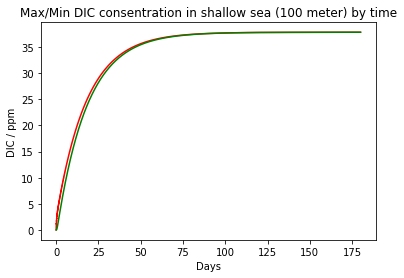

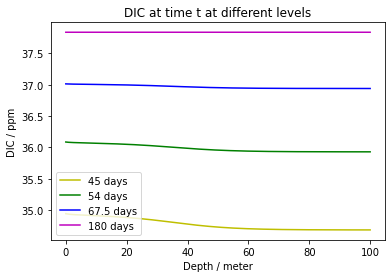

Ser at ved tidene rundt 90+ dager så er konsentrasjonen omtrent uniform (rett graf), mens ved tidene tidligere
er det tydelig at konsentrasjonen ved bunn ikke er like høy. Altså, den avter med dybden. Dette gir mening da CO2-en
kommer fra overflaten.
    Ut fra forrige graf så vi at endringen avtar med tid. Vi velger deretter tidspunkter slik at kurvene ligger med
omtrent lik avstand fra hverandre og er lett synlige på grafen. I denne grafen ser vi også at kurven flater seg ut
med tiden. Dette skjer fordi at CO2 konsentrasjonen i luften er konstant. Denne blir absorbert og fordeler seg jevnt i vannet og når bunnen av
havet til slutt.
    Hvis konsentrasjonen endrer seg sakte gjennom årene, kan vi si at havbunnen ved 100m dybde er synkronisert med
disse endringene, fordi allerede etter 180 dager ser grafen flat ut.


In [31]:
def K1(z): #Funksjonen som representerer fluksen gjennom planet som ligger z-meter under overflaten
    return K0 +Ka*z/za*np.exp(-z/za)+Kb*(L-z)*np.exp(-(L-z)/zb)/zb #Konveksjons "konstanten"
z,dz = np.linspace(0,100,N+1,retstep=True)
C_eq_val1 = 5060*415E-6 #mole/m^3 (415E-6 er her originalt i ppm, men en antagelsen ideel gass tilnærmer det til trykk i atp)
C_eq_vec1 = np.full((M),C_eq_val1)
IC1 = np.zeros(N+1) #initialconditions i oppgave 1
results1,times1,maximum1,minimum1 = Diffusion_solver(C_eq_vec1,IC1,K1,180,z,dz)

plt.figure(0)
plt.title("Max/Min DIC consentration in shallow sea (100 meter) by time")
plt.xlabel("Days")
plt.ylabel("DIC / ppm")
# plt.plot(times1/(3600*24),moleToPpm(results1[:,int(N*3/10)])) #times1/(3600*24) er tid skalert til tid i dager og N*3//10=30 meter
plt.plot(times1/(3600*24),moleToPpm(maximum1),"r",linestyle="-")#Gjør om fra mol/m^3 til ppm
plt.plot(times1/(3600*24),moleToPpm(minimum1),"g",linestyle="-")

print("""Ser at grafene for minimum og maksimum nærmer seg likevekt ved rundt 36 ppm, og differansen nærmer seg her null
mellom maksimum og minumum. Dette vil vil si at konsentrasjonen blir konstant i hele vannkolonnen, som passer bra med
intuisjonen om CO2 inholdet i atmosfæren selv er konstant. Av at grafen er konkavser vi også at det med tid vil være 
mindre endring i konsentrasjoner, da fordelingen er mer uniform. Dette er som forventet da mindre variasjon fører til mindre diffusjon.""")

plt.figure(1)
plt.title("DIC at time t at different levels")
plt.xlabel("Depth / meter")
plt.ylabel("DIC / ppm")
z,dz = np.linspace(0,L,N+1,retstep=True)
# plt.plot(z,moleToPpm(results1[0]),"r",label="0 days")
plt.plot(z,moleToPpm(results1[int(M*0.25)]),"y",label="45 days")
plt.plot(z,moleToPpm(results1[int(M*0.3)]),"g",label="54 days")
plt.plot(z,moleToPpm(results1[int(M*0.375)]),"b",label="67.5 days")
plt.plot(z,moleToPpm(results1[-1]),"m",label="180 days")
plt.legend(loc='best')
plt.show()

print("""Ser at ved tidene rundt 90+ dager så er konsentrasjonen omtrent uniform (rett graf), mens ved tidene tidligere
er det tydelig at konsentrasjonen ved bunn ikke er like høy. Altså, den avter med dybden. Dette gir mening da CO2-en
kommer fra overflaten.
    Ut fra forrige graf så vi at endringen avtar med tid. Vi velger deretter tidspunkter slik at kurvene ligger med
omtrent lik avstand fra hverandre og er lett synlige på grafen. I denne grafen ser vi også at kurven flater seg ut
med tiden. Dette skjer fordi at CO2 konsentrasjonen i luften er konstant. Denne blir absorbert og fordeler seg jevnt i vannet og når bunnen av
havet til slutt.
    Hvis konsentrasjonen endrer seg sakte gjennom årene, kan vi si at havbunnen ved 100m dybde er synkronisert med
disse endringene, fordi allerede etter 180 dager ser grafen flat ut.""")

**Oppgave 2: Varierende CO2 i atmosfæren og dyp sjø(4000 meter)**

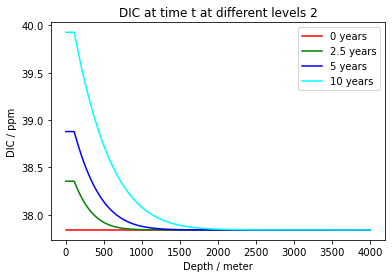

"Merk her at kurven er flat i starten. Dette samsvarer med at de første 100 meterene i følge modellen vår er en
såkalt "high convection zone", som betyr at vi forventer å raskt np likevekt med atmosfæren. Først når vi når "the deep sea"
etter 100 meters dyp så vil blandingen gå vesentlig ned. Dette samsvarer med stupet grafen for konsentrasjon tar etter
z = 100m. 


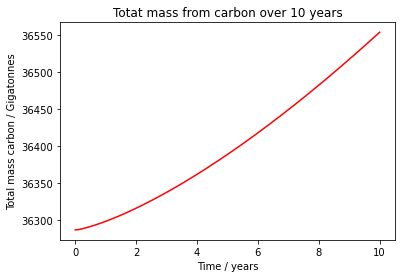

 Ved å ganske enkelt ta slutt-start og dele på 10 år får vi en årlig vekst på gram carbon i havet på: 
2.67e+16g per year.
Gruber et al., 2019, sitt anslag på menneskeskap CO2 (“anthropogenic CO2”) er i følge opplysningene på omtrent 
2.5 × 10^15 g per år. Så til tross for at vi modelerte med kun èn dimensjon, umiddelbar konversjon fra CO2 til DIC ved
absorbsjon i havet, en konstant vindhastighet, ingen absorbsjon av carbon inn i havbunden og totalt så vekk ifra havstrømmer
som spiller stor rolle for verdens økosystem, så treffer vår modell innenfor en ordenstørrelse på Grubers. Ikke dårlig.


In [32]:
K0 = 10e-4#m^2/s
K1 = 10e-2#m^2/s
a = 0.5#m^-1
z0 = 100#meter
period = 365*10#days
z,dz = np.linspace(0,4000,N+1,retstep=True)
def K2(z):
    return K1 + (K0-K1)/(1+np.exp(-a*(z-z0)))

C_eq_val2 = 5060*415E-6 #mole/m^3, dette er likevektsnivået oppgit i startspunktet
C_eq_vec2 = np.array([5060*(415E-6+2.3E-6*step*10/M) for step in range(M)]) #Likevekten øker med 2.3E-6 mole/m^3 årlig. 
IC2 = np.full((N+1),C_eq_val2) #Startsbetingelsen i oppgaven, altså at alt er i likevekt i startstidspunktet.
results2,times2,maximum2,minimum2 = Diffusion_solver(C_eq_vec2,IC2,K2,period,z,dz)#antar ingen skuddår

plt.figure(2)
plt.title("DIC at time t at different levels 2")
plt.xlabel("Depth / meter")
plt.ylabel("DIC / ppm")
plt.plot(z,moleToPpm(results2[0]),"r",linestyle="-")
plt.plot(z,moleToPpm(results2[int(M/4)]),"g",linestyle="-")#10år/4 = 2.5år
plt.plot(z,moleToPpm(results2[int(M/2)]),"b",linestyle="-")#-||-
plt.plot(z,moleToPpm(results2[-1]),"aqua",linestyle="-")#-||-
plt.legend(("0 years","2.5 years","5 years","10 years"))
plt.show()

print(""""Merk her at kurven er flat i starten. Dette samsvarer med at de første 100 meterene i følge modellen vår er en
såkalt "high convection zone", som betyr at vi forventer å raskt np likevekt med atmosfæren. Først når vi når "the deep sea"
etter 100 meters dyp så vil blandingen gå vesentlig ned. Dette samsvarer med stupet grafen for konsentrasjon tar etter
z = 100m. """)

VolumeOcean = 360e12*4000 #overflate * avg_dybde som gitt i oppgaven
carbonmass = np.array([VolumeOcean*sum(results2[t]/(N+1))*12 for t in range(M)])#sum funksjonen/(N+1) finner da 
#gjennomsnittelig mol/m^3. Result har målet mol/m^3, og carbon har molarvekt 12g/mol. Så ganget med havets volum får vi
#total gram carbon om alle DIC-molekyler har et og bare et carbonatom.
plt.figure(3)
plt.title("Totat mass from carbon over 10 years")
plt.xlabel("Time / years")
plt.ylabel("Total mass carbon / Gigatonnes")
plt.plot(times2/(3600*24*365),carbonmass*10**(-6-9),"r",linestyle="-")#endring/år = (slutt-start)/år
plt.show()

print(f""" Ved å ganske enkelt ta slutt-start og dele på 10 år får vi en årlig vekst på gram carbon i havet på: 
{(carbonmass[-1]-carbonmass[0])/10:.2e}g per year.
Gruber et al., 2019, sitt anslag på menneskeskap CO2 (“anthropogenic CO2”) er i følge opplysningene på omtrent 
2.5 × 10^15 g per år. Så til tross for at vi modelerte med kun èn dimensjon, umiddelbar konversjon fra CO2 til DIC ved
absorbsjon i havet, en konstant vindhastighet, ingen absorbsjon av carbon inn i havbunden og totalt så vekk ifra havstrømmer
som spiller stor rolle for verdens økosystem, så treffer vår modell innenfor en ordenstørrelse på Grubers. Ikke dårlig.""")